# **ANÁLISIS NO SUPERVISADO DE CLUSTERIZACIÓN DE LOS 16 FACTORES DE PERSONALIDAD DE CATTELL**

Kmeans

Estamos utilizando como medida de similitud entre features la distancia Euclideana pero podemos utilizar otras diversas funciones que podrían arrojar mejores resultados (como Manhattan, Lavenshtein, Mahalanobis, etc).

En este cuaderno vamos a gacer un analisis del dataset de cattell16PF que contine casi 50000 observaciones que corresponden a respuestasde los pacientes al test de los 16 Factores de Personalid de Cattell

El Cuestionario Factorial de la Personalidad o 16 PF es uno de los instrumentos de medida de la personalidad más conocidos y utilizados a lo largo de la joven historia de la Psicología. Creado como ya se ha dicho por Raymond Cattell a partir de criterios factoriales, este instrumento de evaluación tiene como principal función estudiar y valorar los rasgos de personalidad a partir de diversos factores (dieciséis principales y cinco secundarios o globales en la última versión).

Dichos factores son bipolares, es decir, van en un contínuo que va de un extremo del rasgo al otro, situándose la puntuación de la persona evaluada en algún punto de dicho contínuo.

Para hacerlo más fácil de entender: si uno de los factores es la dominancia, uno de los polos refleja a una persona autoritaria, competitiva e independiente mientras que el otro indicaría una persona sumisa, conformista y dependiente de los dem.

Lo que vamos a intentar predecir es al llegase un nuevo paciente con sus respuestas, a que cluster pertenecería.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 10)
plt.style.use('ggplot')
pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas

In [0]:
!git clone https://gitlab.com/davidllorenteraposo/proyectofinalkcdll.git

fatal: destination path 'proyectofinalkcdll' already exists and is not an empty directory.


In [0]:
#para matar el proceso si se queda pillado
#!kill -9 -1

Cargamos el csv en un dataframe de pandas

In [0]:
cattell16Pf_df = pd.read_csv('proyectofinalkcdll/data/cattell_16pf.csv',encoding="ISO-8859-1")

In [0]:
len(cattell16Pf_df)

49060

Nos creamos una columna para identificar a cada sujeto con un iD

In [0]:
cattell16Pf_df["sujeto"]=""

for i in range(len(cattell16Pf_df)):
  cattell16Pf_df["sujeto"][i]=f"patient_{i}"

Vemos como se nos ha creado la columna identificativa de cada paciente

In [0]:
cattell16Pf_df["sujeto"].size

49060

In [0]:
cattell16Pf_df.head(3)

age gender country  elapsed  warmth  reasoning  emotional_stability  \
0   17   male      US      914    12.0       14.0                 15.0   
1   37   male      US      891    14.0       13.0                 12.0   
2   31   male      US      903    14.0       14.0                 12.0   

   dominance  liveliness  rule_consciousness  social_boldness  sensitivity  \
0       15.0        12.0                13.0             11.0         14.0   
1       14.0        10.0                14.0             12.0         13.0   
2       11.0        11.0                12.0             12.0         11.0   

   vigilance  abstractedness  privateness  apprehension  openness_to_change  \
0       14.0            16.0         14.0          14.0                13.0   
1       12.0            14.0         12.0          12.0                10.0   
2       14.0            14.0         14.0          14.0                12.0   

   self_reliance  perfectionism  tension  baseline     sujeto  
0           17.0           13.0     16.0   13.9375  patient_0  
1           15.0           12.0     12.0   12.5625  patient_1  
2           16.0           12.0     12.0   12.8125  patient_2

Muevo la columna paciente a la primera posición

In [0]:
cols = cattell16Pf_df.columns.tolist()
cols=['sujeto',
 'age',
 'gender',
 'country',
 'elapsed',
 'warmth',
 'reasoning',
 'emotional_stability',
 'dominance',
 'liveliness',
 'rule_consciousness',
 'social_boldness',
 'sensitivity',
 'vigilance',
 'abstractedness',
 'privateness',
 'apprehension',
 'openness_to_change',
 'self_reliance',
 'perfectionism',
 'tension',
 'baseline'
 ]
cattell16Pf_df=cattell16Pf_df[cols]

Cambio los nombres de las columnas al castellano para su mejor comprensión.

In [0]:
cattell16Pf_df.columns=['sujeto','edad','genero','pais','tiempo_t','afabilidad','razonamiento','estabilidad','dominancia',
                        'animacion','atención_normas','atrevimiento','sensibilidad','vigilancia','abstraccion',
                        'privacidad','aprension','apertura_cambio','autosuficiencia','perfeccionismo','tension','baseline']

In [0]:
cattell16Pf_df.shape

(49060, 22)

In [0]:
cattell16Pf_df.head(5)

sujeto  edad  genero pais  tiempo_t  afabilidad  razonamiento  \
0  patient_0    17    male   US       914        12.0          14.0   
1  patient_1    37    male   US       891        14.0          13.0   
2  patient_2    31    male   US       903        14.0          14.0   
3  patient_3    32    male   US       806        14.0          15.0   
4  patient_4    46  female   NZ      1826        13.0          15.0   

   estabilidad  dominancia  animacion  atención_normas  atrevimiento  \
0         15.0        15.0       12.0             13.0          11.0   
1         12.0        14.0       10.0             14.0          12.0   
2         12.0        11.0       11.0             12.0          12.0   
3         12.0        12.0       11.0             13.0          13.0   
4         14.0        13.0       11.0             14.0          10.0   

   sensibilidad  vigilancia  abstraccion  privacidad  aprension  \
0          14.0        14.0         16.0        14.0       14.0   
1          13.0        12.0         14.0        12.0       12.0   
2          11.0        14.0         14.0        14.0       14.0   
3          11.0        12.0         15.0        11.0       14.0   
4          12.0        12.0         13.0        13.0       14.0   

   apertura_cambio  autosuficiencia  perfeccionismo  tension  baseline  
0             13.0             17.0            13.0     16.0   13.9375  
1             10.0             15.0            12.0     12.0   12.5625  
2             12.0             16.0            12.0     12.0   12.8125  
3             12.0             17.0            13.0     13.0   13.0000  
4             11.0             16.0            12.0     13.0   12.8750

Vamoa a hacer una analisis básico de los tipos de datos que manejamos

In [0]:
cattell16Pf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49060 entries, 0 to 49059
Data columns (total 22 columns):
sujeto             49060 non-null object
edad               49060 non-null int64
genero             49060 non-null object
pais               49043 non-null object
tiempo_t           49060 non-null int64
afabilidad         49060 non-null float64
razonamiento       49060 non-null float64
estabilidad        49060 non-null float64
dominancia         49060 non-null float64
animacion          49060 non-null float64
atención_normas    49060 non-null float64
atrevimiento       49060 non-null float64
sensibilidad       49060 non-null float64
vigilancia         49060 non-null float64
abstraccion        49060 non-null float64
privacidad         49060 non-null float64
aprension          49060 non-null float64
apertura_cambio    49060 non-null float64
autosuficiencia    49060 non-null float64
perfeccionismo     49060 non-null float64
tension            49060 non-null float64
baseline        

Vemos que todos las features de los factores de personalidad son float

Las caracteristicas 'genero','sujeto','pais' son de tipo object

Para este análisis de clusterización no nos hace falta transformar las variables objeto en numericas ya que solo vamos a utilizar los factores de personalidad

Aqui podemos ver los estadisticos básicos de las variables numéricas

In [0]:
cattell16Pf_df.describe()

edad      tiempo_t    afabilidad  razonamiento   estabilidad  \
count  49060.000000  4.906000e+04  49060.000000  49060.000000  49060.000000   
mean      25.332165  2.509605e+03     14.063881     13.898553     12.120485   
std       11.010859  5.087938e+04      2.023244      1.773378      1.636265   
min       13.000000  5.000000e+00      1.000000      1.000000      1.000000   
25%       18.000000  5.840000e+02     13.000000     13.000000     11.000000   
50%       21.000000  7.540000e+02     14.000000     14.000000     12.000000   
75%       30.000000  1.045000e+03     15.000000     15.000000     13.000000   
max       79.000000  8.534589e+06     20.000000     20.000000     20.000000   

         dominancia     animacion  atención_normas  atrevimiento  \
count  49060.000000  49060.000000     49060.000000  49060.000000   
mean      12.907134     11.887811        12.898594     12.794395   
std        1.677540      1.943590         1.889940      1.643600   
min        1.000000      1.000000         1.000000      1.000000   
25%       12.000000     11.000000        12.000000     12.000000   
50%       13.000000     12.000000        13.000000     13.000000   
75%       14.000000     13.000000        14.000000     14.000000   
max       20.000000     20.000000        20.000000     20.000000   

       sensibilidad    vigilancia   abstraccion    privacidad     aprension  \
count  49060.000000  49060.000000  49060.000000  49060.000000  49060.000000   
mean      12.365552     12.730840     13.289442     12.842682     13.097065   
std        1.937233      1.746616      2.083608      1.827192      2.085427   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%       12.000000     12.000000     12.000000     12.000000     12.000000   
50%       12.000000     13.000000     13.000000     13.000000     13.000000   
75%       13.000000     14.000000     15.000000     14.000000     14.000000   
max       20.000000     20.000000     20.000000     20.000000     20.000000   

       apertura_cambio  autosuficiencia  perfeccionismo       tension  \
count     49060.000000     49060.000000    49060.000000  49060.000000   
mean         12.529821        14.510436       13.500122     12.610090   
std           1.847326         2.135342        1.974237      1.978525   
min           1.000000         1.000000        1.000000      1.000000   
25%          12.000000        13.000000       13.000000     12.000000   
50%          13.000000        15.000000       14.000000     13.000000   
75%          13.000000        16.000000       15.000000     14.000000   
max          20.000000        20.000000       20.000000     20.000000   

           baseline  
count  49060.000000  
mean      13.002931  
std        1.328496  
min        1.000000  
25%       12.687500  
50%       13.062500  
75%       13.500000  
max       20.000000

Vemos que los indices de los factores van de 1-20 lo que nos será útil para asignar los rangos.

El test 16PF válida los rasgos de personallidad en un rango de 1-20 dependiendo de las respuestas a las preguntas del test

Vamos a ver si existe alguna columna que contenga missings

In [0]:
# Función para calcular los missings
def missing_values(df):
        # Total
        mis_val = df.isnull().sum()
        
        # Porcentaje
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Hago la tabla
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Columnas
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Ordeno
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
       
        print ("El dataframe seleccionado tiene " + str(df.shape[1]) + " columnas.\n"      
            "Existen " + str(mis_val_table_ren_columns.shape[0]) +
              " columnas que tienen missings.")
        
        # Return 
        return mis_val_table_ren_columns

In [0]:
missing_values(cattell16Pf_df)

El dataframe seleccionado tiene 22 columnas.
Existen 1 columnas que tienen missings.


Missing Values  % of Total Values
pais              17                0.0

Vemos que única columna que contiene missings(17) es el pais.

Como nuestro analisis no va a utilizar esta caracteristica lo dejamos estar.

También podemos ver la gráfica de correlación de las variables

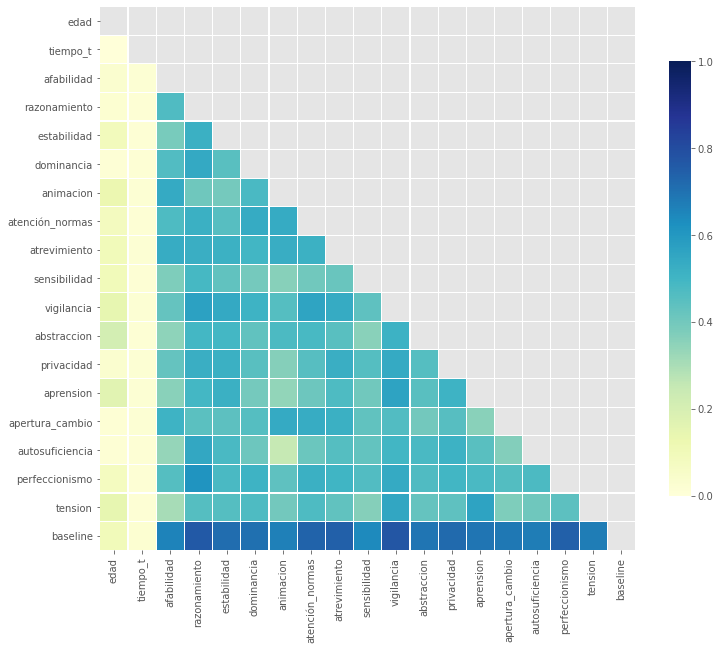

In [0]:
import seaborn as sns
corr = np.abs(cattell16Pf_df.drop(['sujeto'], axis=1).corr())
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Podemos ver que todas caracteristicas que se refieren a factores de personalidad estan muy correlacionadas con la base_line como es lógico.

Pero la edad y el género no lo están , así que es muy bueno para intentar encontrar relaciones en el algoritmo K-means que no haya alta correlacion entre las variables de estudio.

Vemos la dispersión de los datos númericos.

Podemos ver en las gráficas de abajo que los datos que nos interesas estan distribuidos entre los valores entre 5 y 20

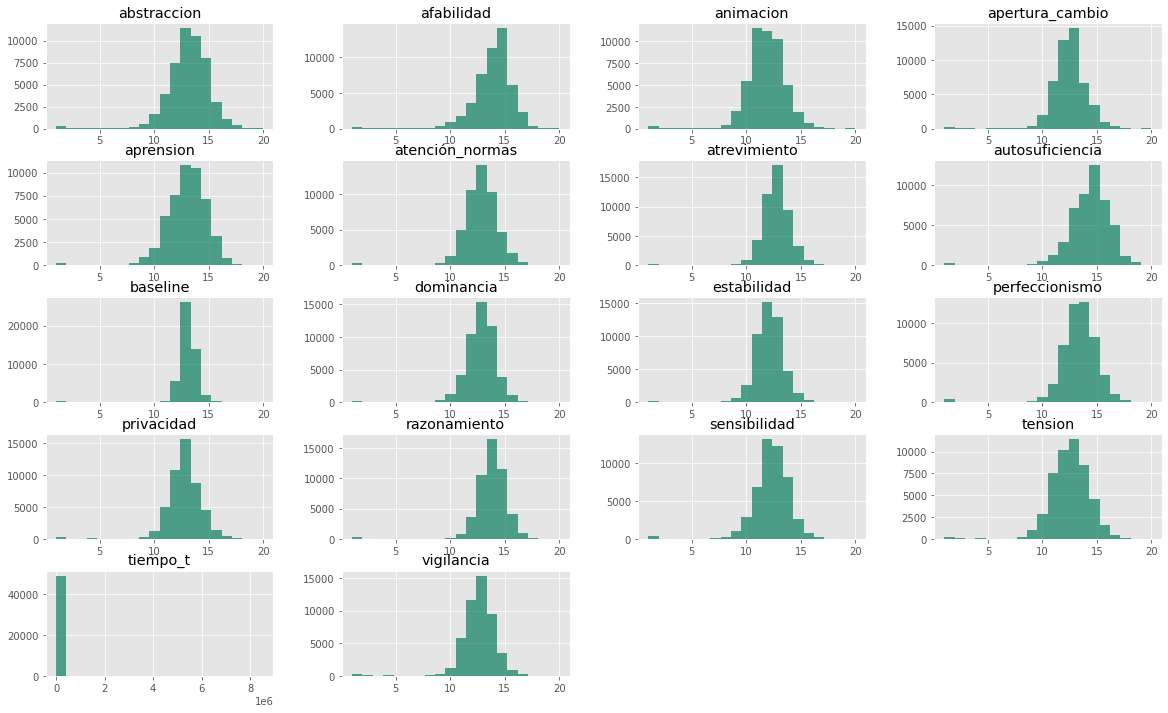

In [0]:
cattell16Pf_df.drop(['edad'],1).hist(figsize=(20,12),bins = 20, color="#007959AA")
plt.title("Features Distribution")
plt.show()

Visualización de las relaciones de las categorias cruzadas.

In [0]:
sb.pairplot(cattell16Pf_df.dropna(), hue='edad',size=4,vars=['afabilidad','razonamiento','estabilidad','dominancia',
                        'animacion','atención_normas','atrevimiento','sensibilidad','vigilancia','abstraccion',
                        'privacidad','aprension','apertura_cambio','autosuficiencia','perfeccionismo','tension'],kind='scatter')

Output hidden; open in https://colab.research.google.com to view.

Parece ser que existe alguna correlación entre las caracteristicas analizadas

Preparamos los datos para el algoritmo K-means, voy a crearme un subset con las 16 columnas que  corresponden con los 16 factores de personalidad de Cattell.

In [0]:
cattellSubset=['afabilidad','razonamiento','estabilidad','dominancia',
        'animacion','atención_normas','atrevimiento','sensibilidad','vigilancia','abstraccion',
        'privacidad','aprension','apertura_cambio','autosuficiencia','perfeccionismo','tension']

In [0]:
cattellFeatures = np.array(cattell16Pf_df[cattellSubset])
label = np.array(cattell16Pf_df['edad'])
cattellFeatures.shape

(49060, 16)

Vamos a mostrar la curva Elbow para calcular el número óptimo de clusters para hallar el valor de k mas óptimo.

In [0]:
Nc = range(1, 20) # En relación a los rangos de los valores de las carcteristicas vistos en las gráficas
kmeans = [KMeans(n_clusters=i) for i in Nc]
#Entrenamos el algoritmo
score = [kmeans[i].fit(cattellFeatures).score(cattellFeatures) for i in range(len(kmeans))]
score

[-2815878.5700978404,
 -1872959.8406378222,
 -1643030.8926224695,
 -1545224.4354704306,
 -1478857.2491372507,
 -1434427.9520860852,
 -1395360.4086611064,
 -1361155.248844258,
 -1332279.7343048346,
 -1309081.1933931352,
 -1289392.8713869695,
 -1272148.1904984158,
 -1257050.4861147995,
 -1243528.399070295,
 -1230923.8120952141,
 -1219103.5811738847,
 -1208234.529493158,
 -1198428.7728850935,
 -1187999.116118525]

Mostramos la curva

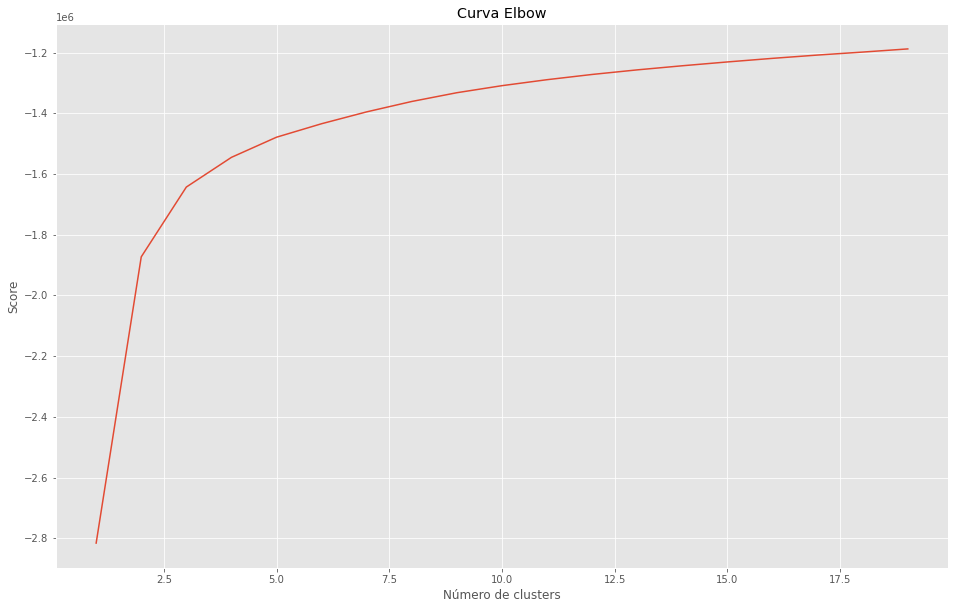

In [0]:
plt.plot(Nc,score)
plt.xlabel('Número de clusters')
plt.ylabel('Score')
plt.title('Curva Elbow')
plt.show()

Podemos ver en la curva que nos indica que existe un codo mas o menos sobre los 2 clusters, otro sobre los 3 .

Luego se ven 2 codos mas suaves en 4 y 5.

Podríamos probar con cada uno de ellos y analizar los resultados.

Voy a optar por el valor 3 de k, ya que conociendo el problema y habiendo hecho un pequeño análisis previo de los datos podemos ver que los valores de edad estan disstribuidos en rangos bastante diferenciados.

Con este valor de k vamos a calcular las etiquetas y sus centroides

In [0]:
kmeans = KMeans(n_clusters=3).fit(cattellFeatures)
centroids = kmeans.cluster_centers_
print(centroids)

[[13.87240889 13.68293048 11.80868817 12.62003293 11.59013695 12.55328145
  12.5330764  12.28863279 12.3174811  12.69385617 12.50680985 12.4059343
  12.38191274 14.114383   13.14667365 11.99087031]
 [14.57511025 14.45259096 12.73116501 13.48957185 12.5102444  13.60170893
  13.35837008 12.73750459 13.5008269  14.27958471 13.51552738 14.20084528
  12.9799706  15.28344359 14.23428886 13.60441933]
 [ 3.4434629   2.77208481  3.35689046  4.06360424  2.00530035  2.16254417
   3.4434629   1.69257951  2.6360424   3.33215548  2.82508834  3.28091873
   2.20141343  3.48233216  1.9540636   3.60777385]]


Hacemos la precicción de las etiquetas y centroides

In [0]:
cattellLabels = kmeans.predict(cattellFeatures)
C = kmeans.cluster_centers_

In [0]:
C.shape

(3, 16)

Podemos graficar por ej

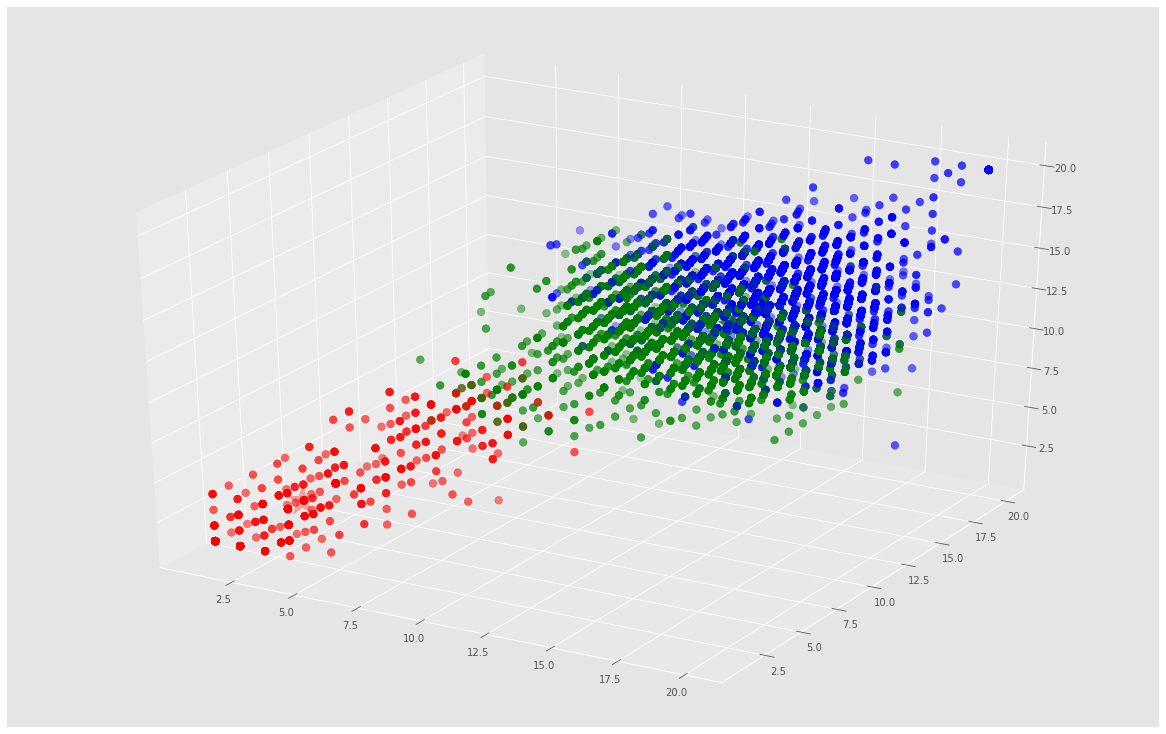

In [0]:
colores=['red','green','blue']
asignar=[]
for row in cattellLabels:
    asignar.append(colores[row])
 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(cattellFeatures[:, 0],cattellFeatures[:, 1], cattellFeatures[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

Podemos ver como se han agrupado todas las observaciones de nuestro dataset en 3 clusters con sus centroides teniendo en cuenta las dimensiones elegidas que son los 16 factores de personalidad de Cattell

Vamoa ver las cauntos elementos tienne nuestros clusters

In [0]:
cattell16Pf_df_copy =  pd.DataFrame()
cattell16Pf_df_copy['sujeto']=cattell16Pf_df['sujeto'].values
cattell16Pf_df_copy['edad']=cattell16Pf_df['edad'].values
cattell16Pf_df_copy['label'] = cattellLabels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=cattell16Pf_df_copy.groupby('label').size()
cantidadGrupo

color  cantidad
0    red     26716
1  green     21778
2   blue       566

En la tabla de arriba podemos ver la cantidad de pacientes que se encuentran en cda uno de los clusters, como vemos la cantidad de pacientes es menos que la total ya que existen edades en las que no hay ningún paciente asociado.

Lo podemos ver mas claramente en la siguiente tabla.

In [0]:
group_referrer_index = cattell16Pf_df_copy['label'] ==0
group_referrals = cattell16Pf_df_copy[group_referrer_index]
 
diversidadGrupo =  pd.DataFrame()
#pongo un rando de 0 años a 100
diversidadGrupo['edad']=range(100)
diversidadGrupo['cantidad']=group_referrals.groupby('edad').size()
diversidadGrupo

Por ejemplo para la edad 40 existen 11 sujetos mientras que para la edad 12 no existe ninguno y para la edad de 68 solo un sujeto.


Esto tiene sentido, el test 16PF de Cattell esta pensado para pacientes de >16 años y es óptimo para personas en edad laboral de los 18 a los 65 años.
Es aquí donde se acumulan la mayoria de observaciones.


In [0]:
diversidadGrupo["cantidad"][17]

2811.0

Podemos ver los representantes de cada grupo , son los que mas cerca estan de los centroides y representan mejor las caracteristicas de ese grupo

In [0]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, cattellFeatures)
closest

array([ 8812, 42846, 22159])

In [0]:
pacientesRep=cattell16Pf_df['sujeto'].values
for row in closest:
    print(pacientesRep[row])


patient_8812
patient_42846
patient_22159


Nos indican que el paciente patient_22159 representa mejor al primer cluster

Nos indican que el paciente patient_42846 representa mejor al primer cluster

Nos indican que el paciente patient_8812 representa mejor al primer cluster

Si vemos la edad de cada uno de ellos

In [0]:
cattell16Pf_df.loc[cattell16Pf_df.loc[:, 'sujeto'] == 'patient_22159']

sujeto  edad genero pais  tiempo_t  afabilidad  razonamiento  \
22159  patient_22159    37   male   IN       235         4.0           3.0   

       estabilidad  dominancia  animacion  atención_normas  atrevimiento  \
22159          3.0         5.0        2.0              2.0           3.0   

       sensibilidad  vigilancia  abstraccion  privacidad  aprension  \
22159           1.0         2.0          4.0         4.0        4.0   

       apertura_cambio  autosuficiencia  perfeccionismo  tension  baseline  
22159              2.0              4.0             1.0      4.0       3.0

In [0]:
cattell16Pf_df.loc[cattell16Pf_df.loc[:, 'sujeto'] == 'patient_42846']

sujeto  edad  genero pais  tiempo_t  afabilidad  razonamiento  \
42846  patient_42846    18  female   AU      1001        14.0          14.0   

       estabilidad  dominancia  animacion  atención_normas  atrevimiento  \
42846         13.0        13.0       13.0             13.0          13.0   

       sensibilidad  vigilancia  abstraccion  privacidad  aprension  \
42846          12.0        13.0         14.0        14.0       14.0   

       apertura_cambio  autosuficiencia  perfeccionismo  tension  baseline  
42846             13.0             15.0            14.0     13.0   13.4375

In [0]:
cattell16Pf_df.loc[cattell16Pf_df.loc[:, 'sujeto'] == 'patient_8812']

sujeto  edad  genero pais  tiempo_t  afabilidad  razonamiento  \
8812  patient_8812    33  female   GB       562        14.0          13.0   

      estabilidad  dominancia  animacion  atención_normas  atrevimiento  \
8812         12.0        13.0       11.0             13.0          12.0   

      sensibilidad  vigilancia  abstraccion  privacidad  aprension  \
8812          12.0        12.0         12.0        12.0       13.0   

      apertura_cambio  autosuficiencia  perfeccionismo  tension  baseline  
8812             12.0             14.0            13.0     12.0      12.5

Ahora podríamos predecir a que cluster perteneciería un nuevo sujeto que introdujramos en  nustra base de datos y hubiese pasado el rest 16PF

In [0]:
catellFeatures_new = np.array([[14,12,9,15,12,13,12,7,4,12,10,11,12,15,19,19]]) 
 
new_labels = kmeans.predict(catellFeatures_new)
print(f'El nuevo paciente corresponde al cluster {new_labels}')

El nuevo paciente corresponde al cluster [0]


En este paso podemos calcular las notas de el 16Pf sin etiquetar e intentar predecir el rango de edad al que pertenece.

In [0]:
cattell16Pf_df_raw = pd.read_csv('proyectofinalkcdll/data/cattles16PFraw.csv',encoding="ISO-8859-1",sep="\t")

In [0]:
cattell16Pf_df_raw.head()

A1  A2  A3  A4  A5  A6  A7  A8  A9  A10  B1  B2  B3  B4  B5  B6  B7  B8  \
0   1   4   2   3   3   2   3   4   4    3   4   4   5   4   5   4   5   4   
1   4   3   4   3   4   4   4   4   2    2   4   4   4   4   5   4   3   2   
2   3   4   4   4   4   4   4   3   2    2   4   4   5   5   4   4   4   4   
3   4   5   4   4   4   3   3   2   2    2   4   2   4   5   4   5   4   4   
4   4   0   4   4   4   3   5   1   2    4   2   4   4   5   5   4   4   5   

   B9  B10  B11  B12  B13  C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  D1  D2  \
0   1    2    1    1    1   4   5   4   4   2   4   4   3   3    2   4   3   
1   3    2    4    1    1   1   2   3   3   2   5   4   4   3    3   4   2   
2   2    2    2    2    2   2   4   4   3   3   3   4   2   3    0   3   3   
3   3    3    3    2    4   3   2   3   4   3   3   2   2   3    4   3   2   
4   4    1    5    1    2   2   4   3   3   4   4   4   4   3    2   5   4   

   D3  D4  D5  D6  D7  D8  D9  D10  E1  E2  E3  E4  E5  E6  E7  E8  E9  E10  \
0   5   5   4   4   3   2   4    3   1   1   4   3   4   5   1   3   3    4   
1   4   4   4   5   4   2   3    1   1   2   4   1   4   2   2   4   2    1   
2   2   2   3   4   3   1   3    3   1   1   3   1   4   2   3   4   2    4   
3   3   4   2   3   3   3   4    3   3   2   4   1   4   4   1   3   2    2   
4   3   4   5   4   1   1   1    3   1   1   3   1   4   2   4   5   2    3   

   F1  F2  F3  F4  F5  F6  F7  F8  F9  F10  G1  G2  G3  G4  G5  G6  G7  G8  \
0   2   2   5   1   1   4   3   5   4    4   3   1   4   2   3   4   3   1   
1   3   4   2   4   5   2   4   4   2    4   3   4   2   4   4   2   3   2   
2   3   4   1   2   3   3   3   2   3    4   2   2   1   3   3   3   3   3   
3   4   3   1   3   2   4   3   4   3    3   2   4   4   4   3   3   3   2   
4   4   4   4   4   4   2   4   4   1    3   3   1   4   2   5   2   1   1   

   G9  G10  H1  H2  H3  H4  H5  H6  H7  H8  H9  H10  I1  I2  I3  I4  I5  I6  \
0   5    1   5   5   5   3   3   3   3   1   2    4   3   4   4   3   4   4   
1   3    3   5   5   5   1   4   3   4   2   1    2   5   4   3   2   4   2   
2   5    4   3   4   3   4   1   4   2   3   0    2   3   4   4   3   4   2   
3   3    3   4   5   2   1   4   2   3   2   2    2   2   2   4   3   4   2   
4   2    2   4   4   3   3   1   4   2   4   1    2   4   2   4   4   2   2   

   I7  I8  I9  I10  J1  J2  J3  J4  J5  J6  J7  J8  J9  J10  K1  K2  K3  K4  \
0   2   4   2    4   5   5   5   5   5   5   5   2   1    1   2   3   2   4   
1   2   2   3    2   5   4   5   4   4   2   4   3   2    2   3   4   2   4   
2   2   3   4    4   4   4   4   5   5   3   3   3   1    1   3   4   4   4   
3   4   2   4    1   5   5   5   5   5   4   4   1   1    1   3   3   1   4   
4   3   2   3    3   3   4   2   4   4   1   2   5   4    2   4   4   1   4   

   K5  K6  K7  K8  K9  K10  L1  L2  L3  L4  L5  L6  L7  L8  L9  L10  M1  M2  \
0   4   5   2   5   2    5   3   4   3   3   5   3   4   4   2    4   5   4   
1   3   2   2   2   3    4   3   4   4   4   2   1   4   2   2    3   4   2   
2   4   3   2   2   3    4   4   3   3   4   4   4   2   3   3    4   3   4   
3   3   2   2   2   3    3   3   2   4   3   4   4   4   4   3    2   4   4   
4   4   2   3   2   2    4   4   2   4   4   4   4   4   1   3    3   2   4   

   M3  M4  M5  M6  M7  M8  M9  M10  N1  N2  N3  N4  N5  N6  N7  N8  N9  N10  \
0   4   4   4   1   1   1   3    3   4   4   4   4   4   5   5   4   4    3   
1   4   4   2   1   1   1   2    2   4   2   4   5   5   5   5   2   4    1   
2   5   4   4   2   1   2   1    2   4   4   5   4   4   5   4   3   4    1   
3   5   3   2   1   4   2   2    2   4   5   5   5   5   5   5   1   3    3   
4   4   4   5   1   2   2   1    2   3   3   4   4   5   4   5   4   4    2   

   O1  O2  O3  O4  O5  O6  O7  O8  O9  O10  P1  P2  P3  P4  P5  P6  P7  P8  \
0   4   2   3   4   3   2   2   4   4    4   5   5   5   4   4   5   1   2   
1   3   2   4   2   3   2   2   3   4    4   4   4   4   2   3   

In [0]:
nuevoPaciente= [int(x) for x in list(cattell16Pf_df.iloc[0, 6:22])]

In [0]:
nuevoPaciente

[14, 15, 15, 12, 13, 11, 14, 14, 16, 14, 14, 13, 17, 13, 16, 13]

In [0]:
nuevoPaciente=np.array(nuevoPaciente)

In [0]:
np.array(nuevoPaciente)

array([14, 15, 15, 12, 13, 11, 14, 14, 16, 14, 14, 13, 17, 13, 16, 13])

In [0]:
new_labels = kmeans.predict(np.array(nuevoPaciente))
print(f'El nuevo paciente corresponde al cluster {new_labels}')